# Time series forecasting

In [947]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.model_selection import train_test_split
import seaborn as sns
from pmdarima import auto_arima
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import optuna
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


In [948]:
# Reading the data
df=pd.read_csv('assessment_data_set.csv')

# Preprocessing

## First steps

In [949]:
# let's take a look to the first 10 rows of the data to understand how data is structured
df.head(10)

,Product,Month,Sales
0,ProductA,2019-03-01,608
1,ProductA,2019-04-01,6838
2,ProductA,2019-05-01,12195
3,ProductA,2019-06-01,26292
4,ProductA,2019-07-01,31547
5,ProductA,2019-08-01,29223
6,ProductA,2019-09-01,17732
7,ProductA,2019-10-01,18103
8,ProductA,2019-11-01,19108
9,ProductA,2019-12-01,21857


In [950]:
# Let's print some information about the data
print(f'the types of the columns are: \n{df.dtypes}')
print('\n')
print(f'the shape of the data is: {df.shape}')
print('\n')
print(f'the categories of the Product variable are: {df.Product.unique()}')
print('\n')
print(f"Some statistics of the data are: \n{df.groupby('Product').describe()}")


the types of the columns are: 
Product    object
Month      object
Sales       int64
dtype: object


the shape of the data is: (127, 3)


the categories of the Product variable are: ['ProductA' 'ProductB' 'ProductC']


Some statistics of the data are: 
         Sales                                                         \
         count          mean           std     min       25%      50%   
Product                                                                 
ProductA  47.0  22218.936170   9218.322038   608.0  14981.00  22090.0   
ProductB  42.0   5752.071429   6312.977387    28.0   1891.50   3986.0   
ProductC  38.0  21006.052632  13712.745048  5290.0  10530.25  17774.0   

                            
              75%      max  
Product                     
ProductA  28591.5  45529.0  
ProductB   6699.0  28984.0  
ProductC  29782.0  58457.0  


In [951]:
# checkinng for null values
df.isnull().sum()

Product    0
Month      0
Sales      0
dtype: int64

In [952]:
# checking how many values we have for each product
df['Product'].value_counts()

ProductA    47
ProductB    42
ProductC    38
Name: Product, dtype: int64

In [953]:
# checking for duplicates
df.duplicated().sum()

0

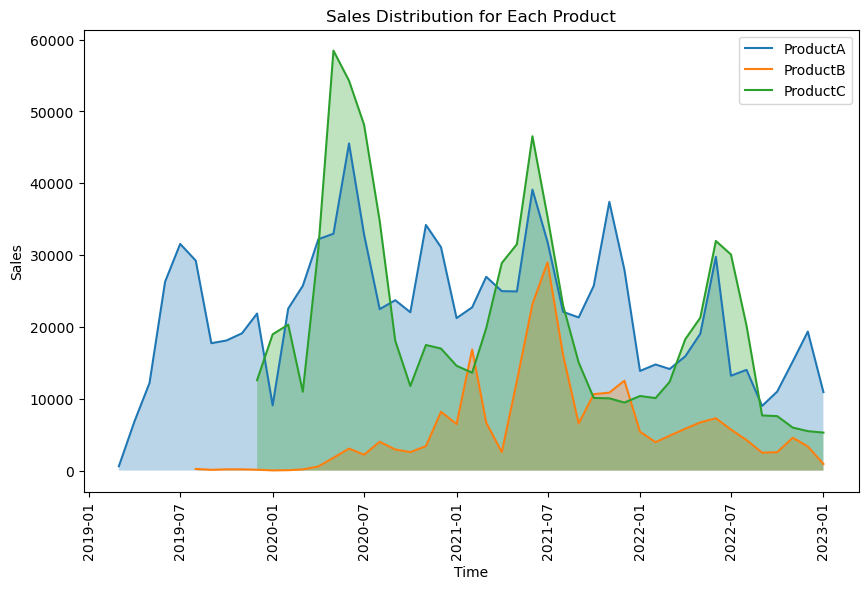

In [954]:
# Let's now plot the beahviour of the sales over time for each product

# Convert 'Month' to just date format without time
df['Month'] = pd.to_datetime(df['Month']).dt.date

# setting the size of the plot
plt.figure(figsize=(10, 6))

# Get the list of unique products
products = df['Product'].unique()

for product in products:
    # Select the data for the current product
    product_data = df[df['Product'] == product]
    # Plot the sales over time for the product
    sns.lineplot(data=product_data, x='Month', y='Sales', label=product)
    # Add shaded area below the line
    plt.fill_between(product_data['Month'], product_data['Sales'], alpha=0.3)

# Add title and labels
plt.title('Sales Distribution for Each Product')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.legend()
plt.show()


- First of all it can be seen clearly that **Product A** is the first one to be sold in terms of period of time.
- In second instance it can be uderstood how **Product B** is the one that struggles the most in terms of sales, <br> 
it increases the amount of units sold later than the other two.
- Moreover it can be seen is that each two picks of **Product A** there is a pick for **Product C**.
- Finally, generally speaking **Product A** is the most sold, even though the picks of **Product C** are higher than the one of **Product A**

All the above mentioned considerations can be due to some marketing strategies (like boundling, discounts ...), that seem to be quite effective looking at the picks.<br>
It would be interestingto replicate them in the future.

In [955]:
# subsetting the dataset for each product, it will be easier to work with the data in later stages.
df_prod_a=df[df['Product']=='ProductA']
df_prod_b=df[df['Product']=='ProductB']
df_prod_c=df[df['Product']=='ProductC']
df_prod_a.head()

,Product,Month,Sales
0,ProductA,2019-03-01,608
1,ProductA,2019-04-01,6838
2,ProductA,2019-05-01,12195
3,ProductA,2019-06-01,26292
4,ProductA,2019-07-01,31547


## Time series decompostion

/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/2562893561.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(df_prod_a['Month'], rotation=90) # Rotate x-axis labels
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/2562893561.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(df_prod_b['Month'], rotation=90) # Rotate x-axis labels
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/2562893561.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(df_prod_c['Month'], rotation=90) # Rotate x-axis labels


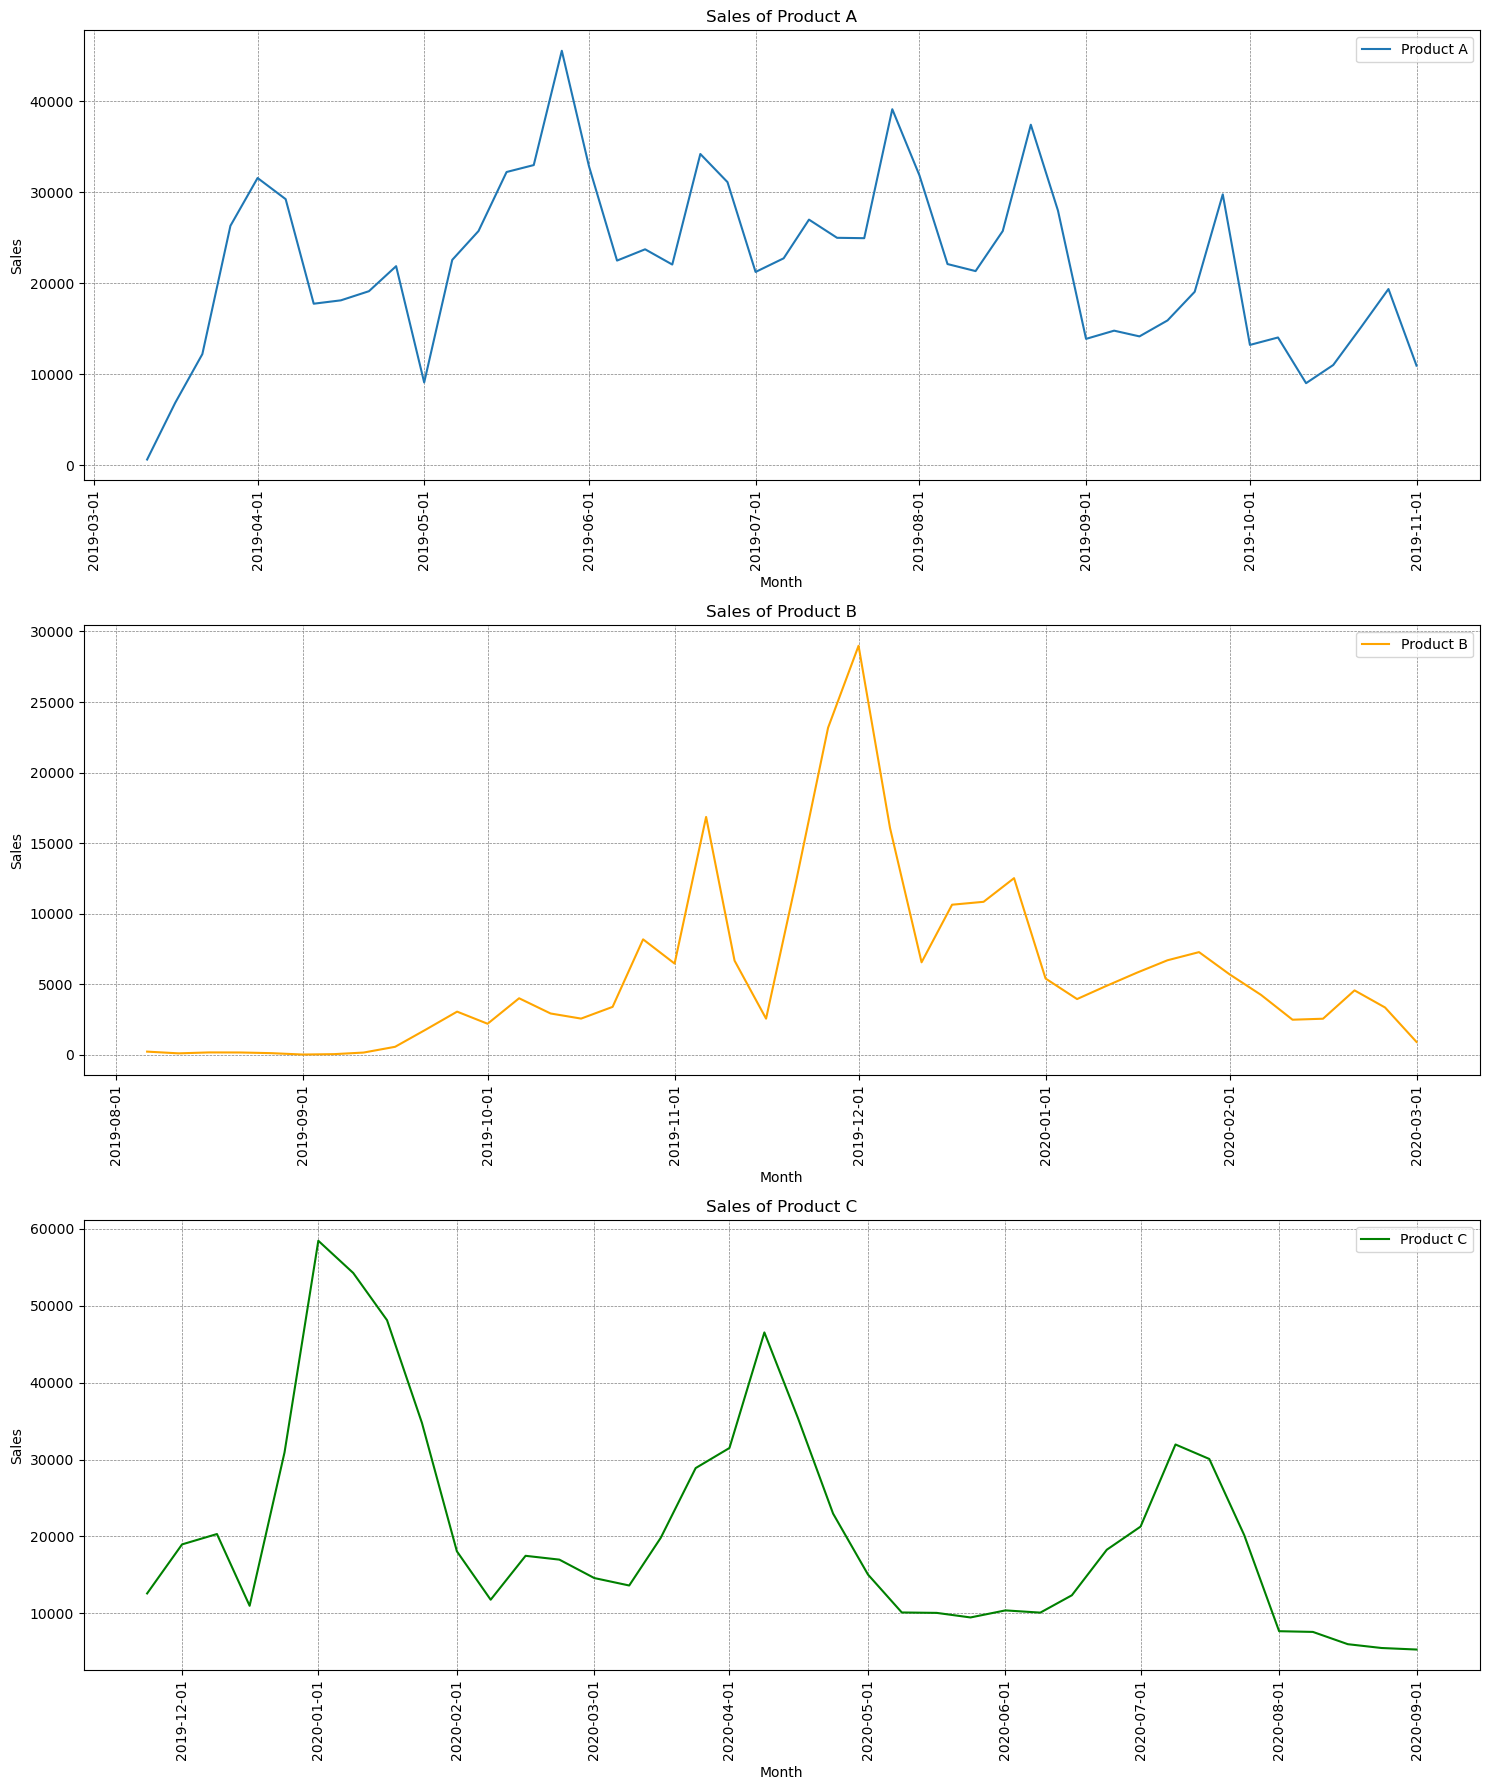

In [956]:
# Plotting one by one in a uniuqe plot the 3 sales behaviour of the products

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(15,18)) # 3 rows, 1 column, and increase the figure size

# Plot Product A's sales on the first subplot
axs[0].plot(df_prod_a['Month'], df_prod_a['Sales'], label='Product A') # plotting the graph
axs[0].grid(color='gray', linestyle='--', linewidth=0.5) # setting the grid in the background to better understand in which period of time there are picks and drops
# setting labels and titles
axs[0].set_xticklabels(df_prod_a['Month'], rotation=90) # Rotate x-axis labels
axs[0].legend() # Legend
axs[0].set_title('Sales of Product A') # Title
axs[0].set_xlabel('Month') # X-axis label
axs[0].set_ylabel('Sales') # Y-axis label

# Plot Product B's sales on the second subplot (the reasoning behind is the same as the first subplot)
axs[1].plot(df_prod_b['Month'], df_prod_b['Sales'], label='Product B', color='orange') # Assuming color differentiation
axs[1].grid(color='gray', linestyle='--', linewidth=0.5) # setting the grid in the background to better understand in which period of time there are picks and drops
axs[1].set_xticklabels(df_prod_b['Month'], rotation=90) # Rotate x-axis labels
axs[1].legend() # Legend
axs[1].set_title('Sales of Product B') # Title
axs[1].set_xlabel('Month') # X-axis label
axs[1].set_ylabel('Sales') # Y-axis label

# Plot Product C's sales on the second subplot (the reasoning behind is the same as the first subplot)
axs[2].plot(df_prod_c['Month'], df_prod_c['Sales'], label='Product C', color='green') # Assuming color differentiation
axs[2].grid(color='gray', linestyle='--', linewidth=0.5) # setting the grid in the background to better understand in which period of time there are picks and drops
axs[2].set_xticklabels(df_prod_c['Month'], rotation=90) # Rotate x-axis labels
axs[2].legend() # Legend
axs[2].set_title('Sales of Product C') # Title
axs[2].set_xlabel('Month') # X-axis label
axs[2].set_ylabel('Sales') # Y-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


From the graphs, we can observe the behavior of the three different products over time: <br>

- For **Product A**, there appears to be a pattern of seasonality, as most of the peaks occur around *May and June*, and significant declines are noted close to *December and January*.<br>
- In contrast, **Product B** does not exhibit the same seasonal pattern. Instead, its sales display a rollercoaster-like behavior throughout *2021*, with sudden increases followed by declines, suggesting a more erratic sales pattern without clear seasonality but with an increaasing and decreasing trend.<br>
- **Product C** shows a return to seasonal behavior, similar to what is observed for Product A. Sales peaks are evident in *May and June*, with drops around *September and October*. Additionally, a decreasing trend is noticeable, as the peaks become progressively lower over time.

In [957]:
# All the information stated before can be also analized more in detailed by decomposing each time series into its components: trend, seasonality and residuals.

def time_series_decomposition(df, product_name):
    # Decompose the time series in trend, seasonality and residuals
    df_plots=df[df['Product']==product_name]['Sales']
    ss_decomposition = seasonal_decompose(x=df_plots, model='additive', period=12)
    estimated_trend = ss_decomposition.trend
    estimated_seasonal = ss_decomposition.seasonal
    estimated_residual = ss_decomposition.resid

    # Plot the decomposition
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False) # 4 rows, 1 column
    fig.set_figheight(10)
    fig.set_figwidth(15)

    # plotting eachh component
    axes[0].plot(df_plots, label='Original')
    axes[0].legend(loc='upper left')
    axes[0].set_title(f'Sales of {product_name}')

    axes[1].plot(estimated_trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(estimated_seasonal, label='Seasonality')
    axes[2].legend(loc='upper left')

    axes[3].plot(estimated_residual, label='Residuals')
    axes[3].legend(loc='upper left')

    plt.show()

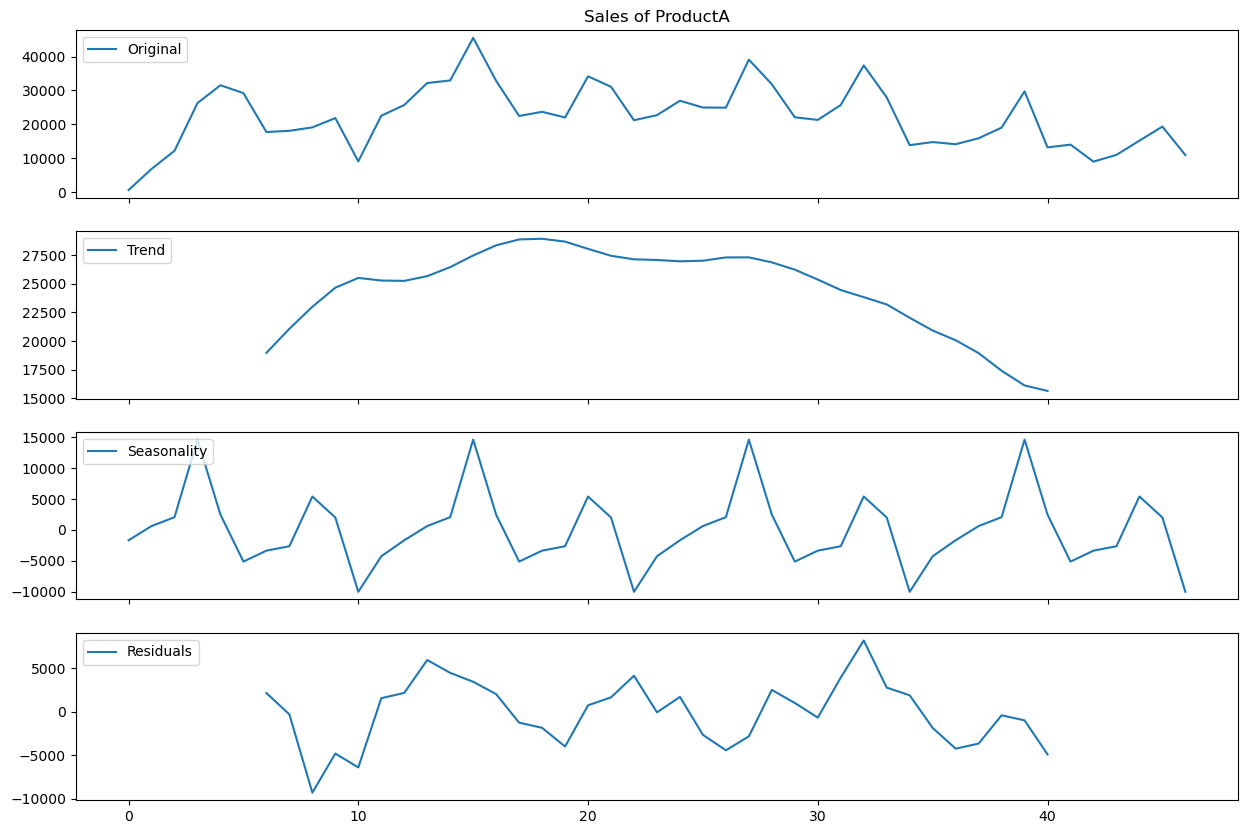

In [958]:
# applying the function to each product
time_series_decomposition(df, 'ProductA')

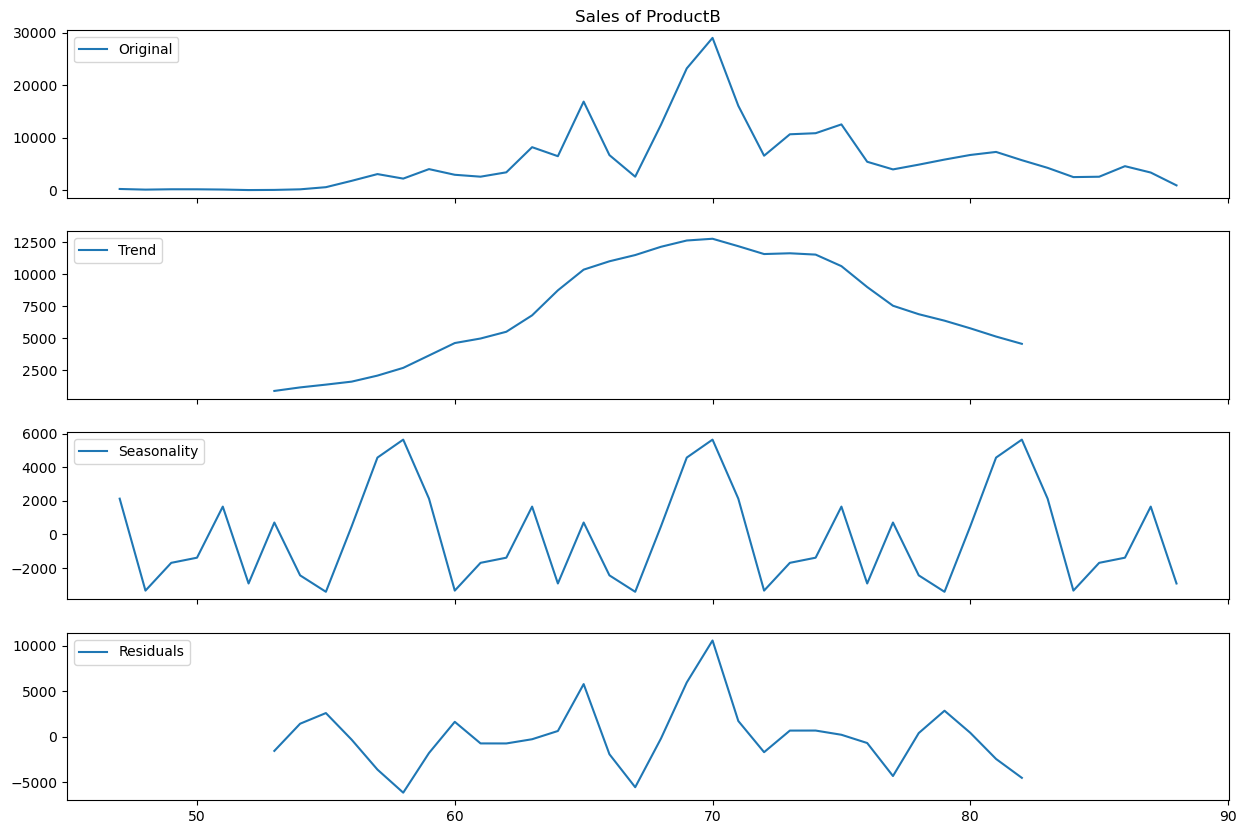

In [959]:
time_series_decomposition(df, 'ProductB')

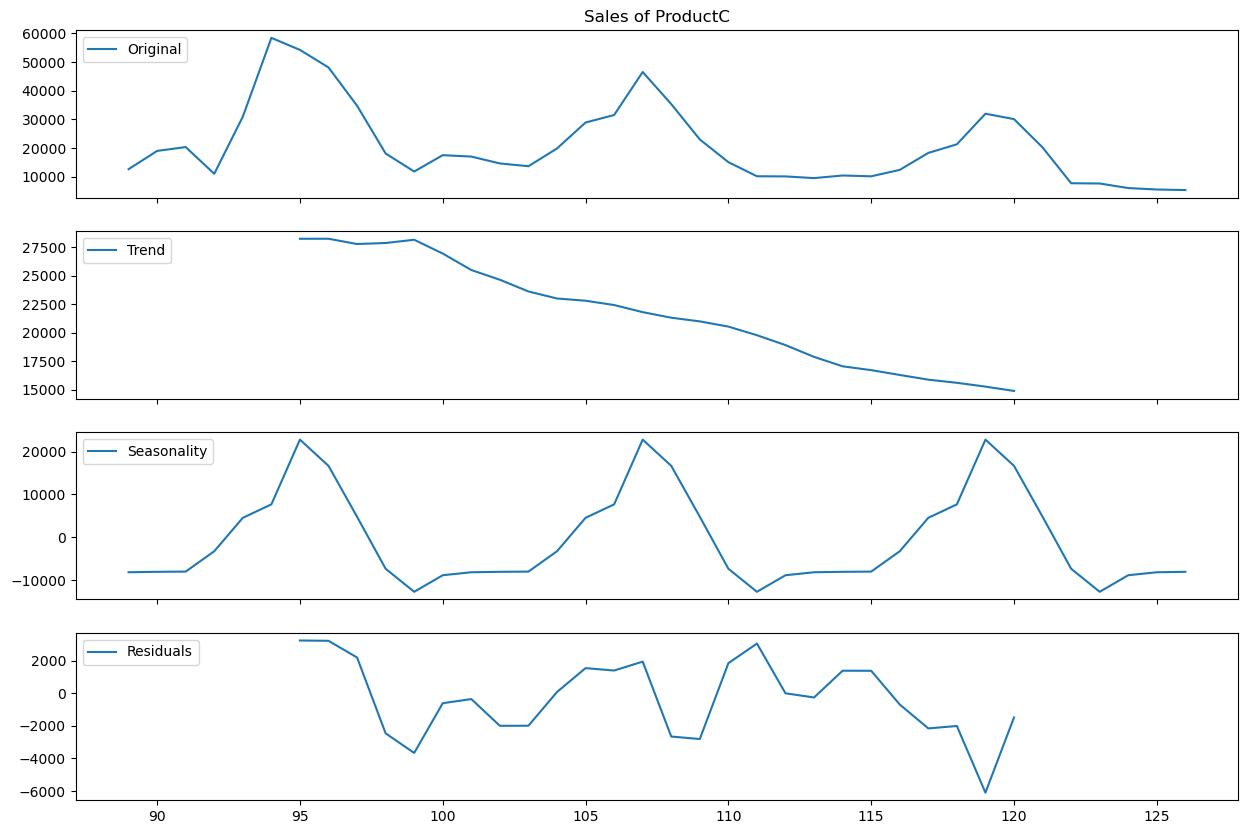

In [960]:
time_series_decomposition(df, 'ProductC')

## Stationarity Checking

From the graphs above can be seen how <u>none</u> of our Products is **stationary**.<br>
>Stationarity means that the <u>statistical properties</u> of a process generating a time series do not change over time. <br>

Long story short it means that our time series should not have a trend or a seasonal behaviour. <br>
Since the non-stationary behaviour of our three time series can hahve a negative effect in the forecasting step, we should make them staionary before building the model.

In [961]:
# A matematical way to measure the stationarity of a time serie is applying the ADF (Augmented Dickey-Fuller) test. 
# This test is based on the null hypothesis that the time serie is not stationary.
# If the p-value is less than 0.05, we can reject the null hypothesis and consider the time serie as stationary.
# This test will be needed to check how many times the time serie needs to be differenced to become stationary.

# To cehck stationarity, we can use the following function
def stationairty_checking(df, product_name):
    # Apply the ADF test
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df[df['Product']==product_name]['Sales'])
    # set the counter that will be used to count the number of times the time serie needs to be differenced
    count=0
    # Print the results
    print(f'ADF round {count}: {adf}')
    print(f'p-value round {count}: {pvalue}')
    # Check if the time serie is stationary
    if pvalue < 0.05:
        print(f'The time serie of {product_name} is stationary')
    else:
        print(f'The time serie of {product_name} is not stationary')
        # If the time serie is not stationary, we need to difference it and check again
        while pvalue > 0.05:
            # Increase the counter
            count+=1
            # Difference the time serie
            diff_ts=df[df['Product']==product_name]['Sales'].diff().dropna()
            # Apply the ADF test again
            adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(diff_ts)
            # Print the results
            print(f'ADF round {count}: {adf}')
            print(f'p-value round {count}: {pvalue}')
    sentence=f'The time serie of {product_name} needs to be differenced {count} times to become stationary'
    diff_dict[product_name]=count
    return sentence


diff_dict={} # Create a dictionary to store the results of the stationarity checking

In [962]:
# Applying the function to each product
stationairty_checking(df, 'ProductA')

ADF round 0: -3.716641145579493
p-value round 0: 0.0038850779964209985
The time serie of ProductA is stationary


'The time serie of ProductA needs to be differenced 0 times to become stationary'

In [963]:
stationairty_checking(df, 'ProductB')

ADF round 0: -1.433136381495828
p-value round 0: 0.5662911115641971
The time serie of ProductB is not stationary
ADF round 1: -6.283143991662907
p-value round 1: 3.7536262386198025e-08


'The time serie of ProductB needs to be differenced 1 times to become stationary'

In [964]:
stationairty_checking(df, 'ProductC')

ADF round 0: -0.06448719110122275
p-value round 0: 0.9528628647292334
The time serie of ProductC is not stationary
ADF round 1: -5.267573555102063
p-value round 1: 6.389240381984626e-06


'The time serie of ProductC needs to be differenced 1 times to become stationary'

In [965]:
# sort dictionary by key
diff_dict = dict(sorted(diff_dict.items()))
diff_dict

{'ProductA': 0, 'ProductB': 1, 'ProductC': 1}

According to the functions used in the chunks above it turned out that the sales time series about **Product B** and **Product C** needs <br>
to be differentiated 1 time in order to be stationary, while the time serie about **Product A** doesn't need any differentiation. <br>
This reasoning makes sense matematically, according to the ADF test but it doesn't graphically since we have seen before that the <br> 
sales of **Product A** follow a seasonal pattern. So we will proceed to differentiate also the sales values regarding **Product A** modifying the diff_dict.

In [966]:
diff_dict['ProductA']=1

# Models

In order to forecast the next 6 months sales for each product we will build some models.<br>
The models i have choosen are:
- **ARIMA**, an auto regressive moving average models, a model quite used when dealing with time series forecasting, often used to set a <u>*treshold*</u> to evaluate other models performances.
- **Ensamble learning methods**(XGB and Random Forest), they are very powerful machine learning methods quite used when dealing with time series too.<br>
 I had preferred them to neural networks because they are computationally less expensive and almost the same (also even better sometimes) in terms of performances.

The very last thing that worth to be mentioned is the way we are going to evaluate our models. The chosen metric will be the **MAPE** (mean absolute percentage error) that wil tell us how much the predictions will be wrong in percentage terms. I chose this metric because, in contrast to RMSE for example, it doesn't depend on the scale of the data and it is easier to interpret.

## Arima

In [967]:
# to fit the ARIMA model we need to find the best parameters for the model. To fullfill this task we will use the auto_arima function from the pmdarima library,
# that will automatically choose the best values for the P and Q values that the ARIMA model needs.
# Notice that the D parameter is already known since we have already differenced the time series.
# Notice also that the auto.arima function wants as input the time series in a non-differenced form. 
# So we need to take the original time series and split it into train and test sets just for this occasion.

# Split the data into train and test sets
split_point_a = int(len(df_prod_a) * 0.8)
split_point_b = int(len(df_prod_b) * 0.8)
split_point_c = int(len(df_prod_c) * 0.8)

train_a_original, test_a_original = df_prod_a['Sales'][0:split_point_a], df_prod_a['Sales'][split_point_a:]
train_b_original, test_b_original = df_prod_b['Sales'][0:split_point_b], df_prod_b['Sales'][split_point_b:]
train_c_original, test_c_original = df_prod_c['Sales'][0:split_point_c], df_prod_c['Sales'][split_point_c:]

/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/1941767972.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_b_original, test_b_original = df_prod_b['Sales'][0:split_point_b], df_prod_b['Sales'][split_point_b:]
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/1941767972.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_c_original, test_c_original = df_prod_c['Sales'][0:split_point_c], df_prod_c['Sales'][split_point_c:]


In [968]:
# to make things faster we can create a function that will do the job for us
def auto_arima_model(train, test, d, bool_seasonal=True):
    # fit the model
    auto_model = auto_arima(train, start_p=0, start_q=0,
                        max_p=5, max_q=5, # Maximum p and q
                        m=12,              # monthly frequence
                        d=d,              # Fixed differencing order
                        seasonal=bool_seasonal,   # Since we have seasonality in Product A
                        start_P=0, 
                        D=1, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

    # predict on the train set
    train_pred=auto_model.predict_in_sample(steps=len(train))

    # Calculate the MAPE
    mape_train=mean_absolute_percentage_error(train, train_pred)*100


    # Try to predict on the test set
    test_pred=auto_model.predict(n_periods=len(test))

    mape_test=mean_absolute_percentage_error(test, test_pred)*100

    print(f'MAPE train set: {mape_train}')
    print('---------------------------------')
    print(f'MAPE test set: {mape_test}')

    

In [969]:
# Applying the function to each product
auto_arima_model(train_a_original, test_a_original, 1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=490.904, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=493.870, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=493.625, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=492.698, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=492.902, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=492.799, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=491.011, Time=0.06 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=494.799, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=493.449, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=494.413, Time=0.16 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=491.292, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 0.971 seconds
MAPE train set: 29.195497337669014
---------------------------------
MAPE test set: 26.85421352299795


In [970]:
auto_arima_model(train_b_original, test_b_original, 1, False)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=641.480, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=643.398, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=643.487, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=639.532, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.060 seconds
MAPE train set: 66.02993303629275
---------------------------------
MAPE test set: 107.57490438013701


/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [971]:
auto_arima_model(train_c_original, test_c_original, 1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=362.517, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=358.500, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=356.191, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=362.365, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=358.190, Time=0.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=357.573, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=360.076, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=358.178, Time=0.03 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=357.520, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total

/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


From the output of the function we can see that the MAPE values for each product, both on the training and on the test set are not so satisfying.<br>
The best performances are in the case of Product A and the worst one are in the case of Product B.<br>
I have used the auto.arima function so that i let the function decide which were the best values to assign to the paramters of the arima model corresponding to <br>
 the *auto regressive* part and to the *moving average* part (remenber that the 'd' parameter, the differenciation parameter, has been alredy decided using ADF test).<br>

## XGB

We will now try to implement an XGB model. Since some X features to use are needed we will construct them. You are maybe guessing how...well it <br> is a common practice when dealing with time series to consider the *previous lags* and also the *month* the *day* corresponding to the sales. 

In [972]:
def create_features(df, lag_count):
    """
    Create lag features for a time series dataframe.
    
    Parameters:
    - df: Pandas DataFrame with a time series column.
    - lag_count: Number of lag features to create.
    
    Returns:
    - df: DataFrame with new lag features.
    """
    # we need first of all to difference the time series since it is not stationary
    df['Sales'] = df['Sales'].diff().dropna()
    # this for loop iterataes over the number of lags we want to create
    # for each lag it creates a new column in the dataframe that is the original time serie shifted by the lag value
    for lag in range(1, lag_count + 1):
        df[f'lag_{lag}'] = df['Sales'].shift(lag)
    return df


### A

we now train an XGB model for the product A

In [973]:
# convert the 'Month' column to datetime
df_prod_a['Month'] = pd.to_datetime(df['Month'])

# considering only the month and the day of the month
df_prod_a['month'] = df_prod_a['Month'].dt.month
df_prod_a['day'] = df_prod_a['Month'].dt.day

# setting as index of the dataframe the varible corresponding to the month
df_prod_a = df_prod_a.set_index('Month')

# dropping the columns that are not needed since for each sub-dataframe the product is the same
df_prod_a = df_prod_a.drop(columns=['Product'])

# creating the lag features using the function we have just created
df_featured_a=create_features(df_prod_a, 3)

# Remove rows with NaN values resulting from lag creation
df_featured_a.dropna(inplace=True)  
df_featured_a.head(10)

/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/426389197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_a['Month'] = pd.to_datetime(df['Month'])
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/426389197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_a['month'] = df_prod_a['Month'].dt.month
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/426389197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,Sales,month,day,lag_1,lag_2,lag_3
Month,,,,,,
2019-07-01,5255.0,7,1,14097.0,5357.0,6230.0
2019-08-01,-2324.0,8,1,5255.0,14097.0,5357.0
2019-09-01,-11491.0,9,1,-2324.0,5255.0,14097.0
2019-10-01,371.0,10,1,-11491.0,-2324.0,5255.0
2019-11-01,1005.0,11,1,371.0,-11491.0,-2324.0
2019-12-01,2749.0,12,1,1005.0,371.0,-11491.0
2020-01-01,-12779.0,1,1,2749.0,1005.0,371.0
2020-02-01,13471.0,2,1,-12779.0,2749.0,1005.0
2020-03-01,3169.0,3,1,13471.0,-12779.0,2749.0


In [974]:
# in order to train the XGB model we need to split the data into train and test sets
# to start we need to divide the dependent (our sales variable) and independent (all the others) variables 
X = df_featured_a.drop(columns='Sales')
y = df_featured_a['Sales']

# Split the data into train and test sets.
# train and test splitting is done before variable transformation to avoid data leakage
# and to ensure that no infiration about the test set are used to train the model.
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(X, y, test_size=0.2, shuffle=False)

In [975]:
# Before letting the model train we need to make some transformations on the data.
# Month and day are considered as categorical variables so we need to one-hot encode them.
# About the sales variable, we need to standardize it.
# These transformations are fundamental in order to build the best model as possible.
# To fullfill this task we will use a pieline containing a ColumnTransformer that will
# apply the transformations to the data, one different for each type of variable.

# setting the pipeline for the numerical variables
num_pipeline=Pipeline([
    ('std_scaler', StandardScaler())
])

# setting the numerical attributes
num_attributes=['lag_1', 'lag_2', 'lag_3']

# setting the categorical attributes
cat_attributes=["month", 'day']

# setting the full pipeline
full_pipeline= ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", OneHotEncoder(), cat_attributes)
])

# applying the pipeline to the train and test sets. We fit and trasnform on the train test and just transofrm on the test set.
X_train_diff_transformed=full_pipeline.fit_transform(X_train_diff)
X_test_diff_transformed=full_pipeline.transform(X_test_diff)

# After having transformed the data we need to create the dataframes from the transformed arrays.
# Here we access the 'cat' transformer's encoder to get the feature names
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = cat_encoder.get_feature_names_out(cat_attributes)

# Concatenate all column names
all_columns = num_attributes + list(cat_one_hot_attribs)

# Create DataFrames from the transformed arrays
X_train_diff_df = pd.DataFrame(X_train_diff_transformed, columns=all_columns, index=X_train_diff.index)
X_test_diff_df = pd.DataFrame(X_test_diff_transformed, columns=all_columns, index=X_test_diff.index)


In [976]:
# The XGBoost model has a lot of hyperparameters that need to be tuned in order to get the best model as possible.
# Rather than tuning them manually or using a grid search, we can use Optuna to find the best hyperparameters for the model.
# Optuna is a hyperparameter optimization framework that uses a technique called Tree-structured Parzen Estimator (TPE) to find the best hyperparameters for a model.

# Defining the Optuna Objective Function that contains the space of possible values for the hyperparameters that we want to tune.
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'random_state': 42,  # Fixing the random state for reproducibility
        'objective': 'reg:squarederror'
    }

    model_xgb = xgb.XGBRegressor(**params)
    model_xgb.fit(X_train_diff_df, y_train_diff)

    # Predict the labels for test data
    predicted_labels = model_xgb.predict(X_test_diff_df)
    
    # Evaluate the model's accuracy (note: this will give average accuracy over all labels)
    # Evaluate the model's accuracy using MAPE
    mape = mean_absolute_percentage_error(y_test_diff, predicted_labels) * 100
    
    return mape


# Optuna Optimization
# Using a fixed seed in Optuna's sampler for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)  # Using a fixed seed
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

# saving the best hyperparameters and the best score
best_params_xgb = study.best_params
best_score_xgb = study.best_value

# printing the results
print('Best Hyperparameters:', best_params_xgb)
print('Best Mape:', best_score_xgb)

[I 2024-02-19 11:42:13,693] A new study created in memory with name: no-name-3a89dccf-a727-4f09-936c-0a3526b65d6d


[I 2024-02-19 11:42:13,763] Trial 0 finished with value: 96.28964257324077 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 6, 'subsample': 0.8195981825434215, 'colsample_bytree': 0.779597545259111, 'n_estimators': 24, 'alpha': 8.629132190071849e-05, 'lambda': 2.231010801867923e-05}. Best is trial 0 with value: 96.28964257324077.
[I 2024-02-19 11:42:13,825] Trial 1 finished with value: 94.86286555119047 and parameters: {'learning_rate': 0.08795585311974417, 'max_depth': 5, 'subsample': 0.8124217733388137, 'colsample_bytree': 0.6061753482887408, 'n_estimators': 98, 'alpha': 0.9877700294007907, 'lambda': 0.00018794668241638458}. Best is trial 1 with value: 94.86286555119047.
[I 2024-02-19 11:42:13,838] Trial 2 finished with value: 80.53441315037338 and parameters: {'learning_rate': 0.02636424704863906, 'max_depth': 3, 'subsample': 0.6912726728878613, 'colsample_bytree': 0.7574269294896714, 'n_estimators': 49, 'alpha': 0.000558952420521792, 'lambda': 0.04689400963537683

Best Hyperparameters: {'learning_rate': 0.09076736504080661, 'max_depth': 6, 'subsample': 0.614146107782397, 'colsample_bytree': 0.7753680632630384, 'n_estimators': 32, 'alpha': 0.00025524290885782703, 'lambda': 0.00018900141265920604}
Best Mape: 39.99272867850065


In [977]:
# once the model has been trained we can use the best paramters found by the optuna optimization
# to train the model again and access the performance of the model.
model_xgb = xgb.XGBRegressor(**best_params_xgb)
model_xgb.fit(X_train_diff_df, y_train_diff)

# Predict the labels for test data
predicted_labels = model_xgb.predict(X_train_diff_df)

# Evaluate the model's accuracy using MAPE
mape = mean_absolute_percentage_error(y_train_diff, predicted_labels) * 100

print(f'MAPE on traning set for product A using XGB is:{mape}%')



MAPE on traning set for product A using XGB is:110.91677949142866%


In [978]:
# Predict the labels for test data
predicted_labels = model_xgb.predict(X_test_diff_df)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape = mean_absolute_percentage_error(y_test_diff, predicted_labels) * 100

print(f'MAPE on test set for product A using XGB is:{mape}%')

MAPE on test set for product A using XGB is:104.06836477364942%


### B

for product B the proceding is exactly the same as done before for product A<br>
Comments will be less detailed to avoid being repetitive

In [979]:
df_prod_b['Month'] = pd.to_datetime(df['Month'])
df_prod_b['month'] = df_prod_b['Month'].dt.month
df_prod_b['day'] = df_prod_b['Month'].dt.day
df_prod_b = df_prod_b.set_index('Month')
df_prod_b = df_prod_b.drop(columns=['Product'])
df_featured_b=create_features(df_prod_b, 3)
df_featured_b.dropna(inplace=True)  # Remove rows with NaN values resulting from lag creation
df_featured_b.head(10)

/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/4029341189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_b['Month'] = pd.to_datetime(df['Month'])
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/4029341189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_b['month'] = df_prod_b['Month'].dt.month
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/4029341189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,Sales,month,day,lag_1,lag_2,lag_3
Month,,,,,,
2019-12-01,-47.0,12,1,-5.0,66.0,-122.0
2020-01-01,-98.0,1,1,-47.0,-5.0,66.0
2020-02-01,28.0,2,1,-98.0,-47.0,-5.0
2020-03-01,112.0,3,1,28.0,-98.0,-47.0
2020-04-01,408.0,4,1,112.0,28.0,-98.0
2020-05-01,1210.0,5,1,408.0,112.0,28.0
2020-06-01,1281.0,6,1,1210.0,408.0,112.0
2020-07-01,-859.0,7,1,1281.0,1210.0,408.0
2020-08-01,1806.0,8,1,-859.0,1281.0,1210.0


In [980]:
X_b = df_featured_b.drop(columns='Sales')
y_b = df_featured_b['Sales']

X_train_diff_b, X_test_diff_b, y_train_diff_b, y_test_diff_b = train_test_split(X_b, y_b, test_size=0.2, shuffle=False)

In [981]:
# in this case we will just apply pipeline on the the 2 dataframes since the pipeline has been already defined before

X_train_diff_transformed_b=full_pipeline.fit_transform(X_train_diff_b)
X_test_diff_transformed_b=full_pipeline.transform(X_test_diff_b)

# This requires fitting the OneHotEncoder, so it's part of your existing pipeline
# Here we access the 'cat' transformer's encoder to get the feature names
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = cat_encoder.get_feature_names_out(cat_attributes)

# Concatenate all column names
all_columns = num_attributes + list(cat_one_hot_attribs)

# Create DataFrames from the transformed arrays
X_train_diff_df_b = pd.DataFrame(X_train_diff_transformed_b, columns=all_columns, index=X_train_diff_b.index)
X_test_diff_df_b = pd.DataFrame(X_test_diff_transformed_b, columns=all_columns, index=X_test_diff_b.index)


In [982]:
# Optuna Objective Function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'random_state': 42,  # Fixing the random state for reproducibility
        'objective': 'reg:squarederror'
    }

    model_xgb_b = xgb.XGBRegressor(**params)
    model_xgb_b.fit(X_train_diff_df_b, y_train_diff_b)

    # Predict the labels for test data
    predicted_labels_b = model_xgb_b.predict(X_test_diff_df_b)
    
    # Evaluate the model's accuracy (note: this will give average accuracy over all labels)
    # Evaluate the model's accuracy using MAPE
    mape_b = mean_absolute_percentage_error(y_test_diff_b, predicted_labels_b) * 100
    
    return mape_b


# Optuna Optimization
import optuna
# Using a fixed seed in Optuna's sampler for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)  # Using a fixed seed
study_b = optuna.create_study(direction='minimize', sampler=sampler)
study_b.optimize(objective, n_trials=100)

best_params_xgb_b = study_b.best_params
best_score_xgb_b = study_b.best_value

print('Best Hyperparameters:', best_params_xgb_b)
print('Best Mape:', best_score_xgb_b)




[I 2024-02-19 11:42:17,381] A new study created in memory with name: no-name-f5a1088d-0b74-4eb8-a4a5-45926b5fab5b
[I 2024-02-19 11:42:17,406] Trial 0 finished with value: 433.49539236805504 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 6, 'subsample': 0.8195981825434215, 'colsample_bytree': 0.779597545259111, 'n_estimators': 24, 'alpha': 8.629132190071849e-05, 'lambda': 2.231010801867923e-05}. Best is trial 0 with value: 433.49539236805504.
[I 2024-02-19 11:42:17,451] Trial 1 finished with value: 700.3109928860958 and parameters: {'learning_rate': 0.08795585311974417, 'max_depth': 5, 'subsample': 0.8124217733388137, 'colsample_bytree': 0.6061753482887408, 'n_estimators': 98, 'alpha': 0.9877700294007907, 'lambda': 0.00018794668241638458}. Best is trial 0 with value: 433.49539236805504.
[I 2024-02-19 11:42:17,464] Trial 2 finished with value: 363.71477745243703 and parameters: {'learning_rate': 0.02636424704863906, 'max_depth': 3, 'subsample': 0.6912726728878613, 'c

Best Hyperparameters: {'learning_rate': 0.028315852234389077, 'max_depth': 6, 'subsample': 0.6626241458006786, 'colsample_bytree': 0.7554323800736477, 'n_estimators': 10, 'alpha': 1.434597825903248, 'lambda': 2.4111482593975824}
Best Mape: 117.7624426127198


In [983]:
model_xgb_b = xgb.XGBRegressor(**best_params_xgb_b)
model_xgb_b.fit(X_train_diff_df_b, y_train_diff_b)

# Predict the labels for test data
predicted_labels_b = model_xgb_b.predict(X_train_diff_df_b)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape_train_xgb_b = mean_absolute_percentage_error(y_train_diff_b, predicted_labels_b)*100

print(f'MAPE on training set for product B is:{mape_train_xgb_b}%')

# Predict the labels for test data
predicted_labels_b_test = model_xgb_b.predict(X_test_diff_df_b)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape_test_xgb_b = mean_absolute_percentage_error(y_test_diff_b, predicted_labels_b_test)*100

print(f'MAPE on test set for product B is:{mape_test_xgb_b}%')


MAPE on training set for product B is:91.58138704315813%
MAPE on test set for product B is:85.13381827602102%


### C

In [984]:
df_prod_c['Month'] = pd.to_datetime(df['Month'])
df_prod_c['month'] = df_prod_c['Month'].dt.month
df_prod_c['day'] = df_prod_c['Month'].dt.day
df_prod_c = df_prod_c.set_index('Month')
df_prod_c = df_prod_c.drop(columns=['Product'])
df_featured_c=create_features(df_prod_c, 3)
df_featured_c.dropna(inplace=True)  # Remove rows with NaN values resulting from lag creation
df_featured_c
X_c = df_featured_c.drop(columns='Sales')
y_c = df_featured_c['Sales']
X_train_diff_c, X_test_diff_c, y_train_diff_c, y_test_diff_c = train_test_split(X_c, y_c, test_size=0.2, shuffle=False)

/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/3695129454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_c['Month'] = pd.to_datetime(df['Month'])
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/3695129454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prod_c['month'] = df_prod_c['Month'].dt.month
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/3695129454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [985]:
X_train_diff_transformed_c=full_pipeline.fit_transform(X_train_diff_c)
X_test_diff_transformed_c=full_pipeline.transform(X_test_diff_c)

# This requires fitting the OneHotEncoder, so it's part of your existing pipeline
# Here we access the 'cat' transformer's encoder to get the feature names
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = cat_encoder.get_feature_names_out(cat_attributes)

# Concatenate all column names
all_columns = num_attributes + list(cat_one_hot_attribs)

# Create DataFrames from the transformed arrays
X_train_diff_df_c = pd.DataFrame(X_train_diff_transformed_c, columns=all_columns, index=X_train_diff_c.index)
X_test_diff_df_c = pd.DataFrame(X_test_diff_transformed_c, columns=all_columns, index=X_test_diff_c.index)


In [986]:
# Optuna Objective Function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'alpha': trial.suggest_float('alpha', 1e-5, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-5, 10, log=True),
        'random_state': 556,  # Fixing the random state for reproducibility
        'objective': 'reg:squarederror'
    }

    model_xgb_c = xgb.XGBRegressor(**params)
    model_xgb_c.fit(X_train_diff_df_c, y_train_diff_c)

    # Predict the labels for test data
    predicted_labels_c = model_xgb_c.predict(X_test_diff_df_c)
    
    # Evaluate the model's accuracy (note: this will give average accuracy over all labels)
    # Evaluate the model's accuracy using MAPE
    mape_c = mean_absolute_percentage_error(y_test_diff_c, predicted_labels_c) * 100
    
    return mape_c


# Optuna Optimization
import optuna
# Using a fixed seed in Optuna's sampler for reproducibility
sampler = optuna.samplers.TPESampler(seed=556)  # Using a fixed seed
study_c = optuna.create_study(direction='minimize', sampler=sampler)
study_c.optimize(objective, n_trials=100)

best_params_xgb_c = study_c.best_params
best_score_xgb_c = study_c.best_value

print('Best Hyperparameters:', best_params_xgb_c)
print('Best Mape:', best_score_xgb_c)

[I 2024-02-19 11:42:20,825] A new study created in memory with name: no-name-98daf200-fbb2-4815-a2e3-184ad7d6f55e
[I 2024-02-19 11:42:20,867] Trial 0 finished with value: 612.0032527339921 and parameters: {'learning_rate': 0.08471160468945302, 'max_depth': 4, 'subsample': 0.8336985511814299, 'colsample_bytree': 0.7617262605892966, 'n_estimators': 27, 'alpha': 0.00317392532732726, 'lambda': 0.0001131293987815294}. Best is trial 0 with value: 612.0032527339921.
[I 2024-02-19 11:42:20,883] Trial 1 finished with value: 334.2552784076295 and parameters: {'learning_rate': 0.02491949004771959, 'max_depth': 4, 'subsample': 0.8709045678115344, 'colsample_bytree': 0.8581890928136822, 'n_estimators': 11, 'alpha': 5.304296281479902e-05, 'lambda': 0.5670241483950513}. Best is trial 1 with value: 334.2552784076295.
[I 2024-02-19 11:42:20,911] Trial 2 finished with value: 680.5818279047963 and parameters: {'learning_rate': 0.024131712265915088, 'max_depth': 3, 'subsample': 0.7426871438652622, 'colsam

Best Hyperparameters: {'learning_rate': 0.01263621100573089, 'max_depth': 3, 'subsample': 0.6112033454282593, 'colsample_bytree': 0.6937215064905888, 'n_estimators': 10, 'alpha': 0.0003518631474844097, 'lambda': 6.705957759706545}
Best Mape: 109.8064910403396


In [987]:
model_xgb_c = xgb.XGBRegressor(**best_params_xgb_c)
model_xgb_c.fit(X_train_diff_df_c, y_train_diff_c)

# Predict the labels for test data
predicted_labels_c = model_xgb_c.predict(X_train_diff_df_c)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape_train_xgb_c = mean_absolute_percentage_error(y_train_diff_c, predicted_labels_c)*100

print(f'MAPE on training set for product C is:{mape_train_xgb_c}%')

# Predict the labels for test data
predicted_labels_c_test = model_xgb_c.predict(X_test_diff_df_c)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape_test_xgb_c = mean_absolute_percentage_error(y_test_diff_c, predicted_labels_c_test)*100

print(f'MAPE on test set for product B is:{mape_test_xgb_c}%')


MAPE on training set for product C is:101.71766415749799%
MAPE on test set for product B is:115.01482099092004%


## Random forrest

we will now fit a third model after Arima and XGB: a random forrest. The approach wll be the same used for XGB. We will tune the hyperparametrs using the opruna library.<br>
The data will be the same used in the step before

#### A

In [988]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': 42  # Fixing the random state for reproducibility
    }
        
    # Create and train the model with a fixed random state
    model = RandomForestRegressor(**params)
    model.fit(X_train_diff_df, y_train_diff)
    
    # Make predictions and evaluate the model
    preds = model.predict(X_test_diff_df)
    mape = mean_absolute_percentage_error(y_test_diff, preds)
    
    return mape

# Using a fixed seed in Optuna's sampler for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)  # Using a fixed seed
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

# saving the best hyperparameters and the best score
best_params = study.best_params
best_score = study.best_value

print('Best Parameters:', best_params)
print('Best Score:', best_score)


[I 2024-02-19 11:42:23,738] A new study created in memory with name: no-name-f0f5e269-37fa-4af7-af6a-c9b6c1eac8c2
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[I 2024-02-19 11:42:24,030] Trial 0 finished with value: 1.3142285536136655 and parameters: {'n_estimators': 437, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto'}. Best is trial 0 with value: 1.3142285536136655.
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

Best Parameters: {'n_estimators': 174, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'auto'}
Best Score: 0.8454687902305806


In [989]:
# Create and train the model using the parameters found by Optuna
model = RandomForestRegressor(**best_params)
model.fit(X_train_diff_df, y_train_diff)

# Predict the labels for test data
predicted_labels_train_rf = model.predict(X_train_diff_df)

# Evaluate the model's accuracy using MAPE
mape_train_rf = mean_absolute_percentage_error(y_train_diff, predicted_labels_train_rf)
mape_train_rf=mape_train_rf.round(2)
print(f'MAPE on training set using random forest for product A is: {mape_train_rf}%')

MAPE on training set using random forest for product A is: 0.89%


/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [990]:
# Predict the labels for test data
predicted_labels_test_rf = model.predict(X_test_diff_df)

# Evaluate the model's accuracy using MAPE
mape_test_rf = mean_absolute_percentage_error(y_test_diff, predicted_labels_test_rf)
mape_test_rf=mape_test_rf.round(2)
print(f'MAPE on test set using random forest for product A is: {mape_test_rf}%')

MAPE on test set using random forest for product A is: 1.13%


#### B

Again, as happened for the XGB case, we will now train a random forrest on the product B data. 

In [991]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': 42  # Fixing the random state for reproducibility
    }
        
    # Create and train the model with a fixed random state
    model_b = RandomForestRegressor(**params)
    model_b.fit(X_train_diff_df_b, y_train_diff_b)
    
    # Make predictions and evaluate the model
    preds_b = model_b.predict(X_test_diff_df_b)
    mape = mean_absolute_percentage_error(y_test_diff_b, preds_b)
    
    return mape

# Using a fixed seed in Optuna's sampler for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)  # Using a fixed seed
study_b = optuna.create_study(direction='minimize', sampler=sampler)
study_b.optimize(objective, n_trials=100)

# saving the best hyperparameters and the best score
best_params_b = study_b.best_params
best_score_b = study_b.best_value

print('Best Parameters:', best_params_b)
print('Best Score:', best_score_b)


[I 2024-02-19 11:42:49,960] A new study created in memory with name: no-name-4f10c412-2c4b-499b-981e-cf25e2eef916
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[I 2024-02-19 11:42:50,282] Trial 0 finished with value: 5.26516283944216 and parameters: {'n_estimators': 437, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto'}. Best is trial 0 with value: 5.26516283944216.
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this 

Best Parameters: {'n_estimators': 288, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
Best Score: 2.492602258536353


In [992]:
# Create and train the model with a fixed random state
model_rf_b = RandomForestRegressor(**best_params_b)
model_rf_b.fit(X_train_diff_df_b, y_train_diff_b)

# Predict the labels for test data
predicted_labels_train_rf_b = model_rf_b.predict(X_train_diff_df_b)

# Evaluate the model's accuracy using MAPE
mape_train_rf_b = mean_absolute_percentage_error(y_train_diff_b, predicted_labels_train_rf_b)
mape_train_rf_b=mape_train_rf_b.round(2)
print(f'MAPE on training set using random forest for product B is: {mape_train_rf_b}%')

# Predict the labels for test data
predicted_labels_test_rf_b = model_rf_b.predict(X_test_diff_df_b)

# Evaluate the model's accuracy using MAPE
mape_test_rf_b = mean_absolute_percentage_error(y_test_diff_b, predicted_labels_test_rf_b)
mape_test_rf_b=mape_test_rf_b.round(2)
print(f'MAPE on test set using random forest for product B is: {mape_test_rf_b}%')

MAPE on training set using random forest for product B is: 2.66%
MAPE on test set using random forest for product B is: 2.6%


#### C

Training a random forrest for product C

In [993]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'random_state': 42  # Fixing the random state for reproducibility
    }
        
    # Create and train the model with a fixed random state
    model_c = RandomForestRegressor(**params)
    model_c.fit(X_train_diff_df_c, y_train_diff_c)
    
    # Make predictions and evaluate the model
    preds_c = model_c.predict(X_test_diff_df_c)
    mape = mean_absolute_percentage_error(y_test_diff_c, preds_c)
    
    return mape

# Using a fixed seed in Optuna's sampler for reproducibility
sampler = optuna.samplers.TPESampler(seed=42)  # Using a fixed seed
study_c = optuna.create_study(direction='minimize', sampler=sampler)
study_c.optimize(objective, n_trials=100)

# saving the best hyperparameters and the best score
best_params_c = study_c.best_params
best_score_c = study_c.best_value

print('Best Parameters:', best_params_c)
print('Best Score:', best_score_c)


[I 2024-02-19 11:43:17,139] A new study created in memory with name: no-name-0fb678fe-6998-44c2-8aa1-9cb0e0460f31
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
[I 2024-02-19 11:43:17,406] Trial 0 finished with value: 8.373869501728885 and parameters: {'n_estimators': 437, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto'}. Best is trial 0 with value: 8.373869501728885.
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove thi

Best Parameters: {'n_estimators': 627, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
Best Score: 1.8601932244716042


In [994]:
# Create and train the model with a fixed random state
model_rf_c = RandomForestRegressor(**best_params_c)
model_rf_c.fit(X_train_diff_df_c, y_train_diff_c)

# Predict the labels for test data
predicted_labels_train_rf_c = model_rf_c.predict(X_train_diff_df_c)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape_train_rf_c = mean_absolute_percentage_error(y_train_diff_c, predicted_labels_train_rf_c)
mape_train_rf_c=mape_train_rf_c.round(2)
print(f'MAPE on training set using random forest for product C is: {mape_train_rf_c}%')

# Predict the labels for test data
predicted_labels_test_rf_c = model_rf_c.predict(X_test_diff_df_c)

# Evaluate the model's accuracy (note: this will give average accuracy over all labels)
# Evaluate the model's accuracy using MAPE
mape_test_rf_c = mean_absolute_percentage_error(y_test_diff_c, predicted_labels_test_rf_c)
mape_test_rf_c=mape_test_rf_c.round(2)
print(f'MAPE on test set using random forest for product C is: {mape_test_rf_c}%')

MAPE on training set using random forest for product C is: 1.66%
MAPE on test set using random forest for product C is: 2.31%


# Next 6 months

After having trained the models we will now forecast the sales value for each product for the next 6 months. <br>
If on one side for the arima model is easier to predict the next 6 monthly values, for XGB and Random Forrest it is a bit more difficult. We need, indeed, to put the forecasted values as lagged values at each step of the prediction.<br>
In this section we will undertake some steps:
- Prepare the data: from the original dataset we need to filter according to the product whose sales need to be forecasted, and apply all the transformation that have been applied to the data before training the models. We do this because this time the train and test split it is no more needed.
- Forecast the values using the models previously trained.
- Put the forecasted values in the dataframe updating each time the lags.
- Since our models have been trained on differentiated dataframes, the prediction outputs are differences so we need to transform back them to actual sales values before considering them as final predictions

Each of this steps will be done using some functions built in the chunks below.
<br>
<br>
From the section before we had the chance to access the performances of the different models and what could have been noticed was that the XGBoost model was very bad in terms of MAPE score, way worse than our trashold model Arima; while the performances of Random Forrest models were quite good. <br>
For this reason only the random forrest models will be used for forecasting the next 6 months sales (together with the Arima model to make some comparisons).

In [995]:
def data_preparation(df, product_name):
    """
    Prepare the data for modeling by filtering the data for a specific product,
    extracting time components, setting the datetime index, creating lagged features,
    and transforming the data using a pipeline.
    
    Parameters:
    - df: Pandas DataFrame with 'Product' and 'Month' columns, among others.
    - product_name: String name of the product to filter the DataFrame for.
    
    Returns:
    - X_transformed_final: DataFrame of transformed features ready for modeling.
    - y: Series of target variable 'Sales'.
    """
    # Filter the DataFrame for the rows where 'Product' matches the product_name
    df2 = df[df['Product'] == product_name]
    
    # Convert the 'Month' column to datetime format
    df2['Month'] = pd.to_datetime(df2['Month'])
    
    # Extract month and day from the 'Month' column (assuming 'Month' actually contains full dates)
    df2['month'] = df2['Month'].dt.month
    df2['day'] = df2['Month'].dt.day
    
    # Set the 'Month' column as the index of the DataFrame
    df2 = df2.set_index('Month')
    
    # Drop the 'Product' column as it's no longer needed (all rows have the same product)
    df2 = df2.drop(columns=['Product'])
    
    # Create lagged features using the create_features function
    df_featured = create_features(df2, 3)
    
    # Remove rows with NaN values resulting from lag creation
    df_featured.dropna(inplace=True)
    
    # Separate the features (X) and target variable (y)
    X = df_featured.drop(columns='Sales')
    y = df_featured['Sales']
    
    # Transform the features using the predefined pipeline 'full_pipeline'
    X_transformed = full_pipeline.transform(X)
    
    # Extract feature names for categorical attributes after transformation
    cat_encoder = full_pipeline.named_transformers_["cat"]
    cat_one_hot_attribs = cat_encoder.get_feature_names_out(cat_attributes)
    
    # Combine numerical and categorical feature names
    all_columns = num_attributes + list(cat_one_hot_attribs)
    
    # Create a DataFrame from the transformed feature array with the correct column names
    X_transformed_final = pd.DataFrame(X_transformed, columns=all_columns, index=X.index)
    
    # Return the transformed features and the target variable
    return X_transformed_final, y

In [996]:
def generate_future_features(df, months_ahead=6):
    """
    Generate a DataFrame with future feature values for a specified number of months ahead.
    
    Parameters:
    - df: Pandas DataFrame with DateTimeIndex and existing features.
    - months_ahead: Integer specifying how many months in the future to generate features for.
    
    Returns:
    - future_features_df: DataFrame with future features for the specified number of months ahead.
    """
    # Assuming 'df' has a DateTimeIndex
    # Get the last date from the DataFrame's index to know where to start generating features
    last_date = df.index[-1]
    
    # Initialize a list to hold the future feature rows
    future_features = []
    
    # Loop over the number of months we want to generate features for
    for i in range(1, months_ahead + 1):
        # Calculate the future date 'i' months ahead from the last date in the DataFrame
        future_date = pd.date_range(start=last_date, periods=i+1, freq='M')[-1]
        
        # Initialize a new row for future features by copying the last row of the DataFrame
        # This is a placeholder and your actual implementation may vary
        new_row = df.iloc[-1].copy()
        
        # The new row's lag features could be set to NaN or calculated based on your model's requirements
        # If your model predicts future values, you would fill these in with your model's predictions
        
        # Initialize all monthly features to 0 as we'll set the correct month to 1 below
        for m in range(1, 13):
            new_row[f'month_{m}'] = 0
        # Set the feature corresponding to the future month to 1
        new_row[f'month_{future_date.month}'] = 1
        
        # Append the newly created row with future features to the list
        future_features.append(new_row)
    
    # Convert the list of Series objects to a DataFrame
    # The DataFrame index is set to the start of each future month
    future_features_df = pd.DataFrame(future_features, index=pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=months_ahead, freq='M'))
    
    # Return the DataFrame with future features
    return future_features_df

In [997]:
def forecast_with_model(model, df, months_ahead=6):
    """
    Generate future sales predictions using a trained model, based on existing data
    and generated future features for a specified number of months ahead.

    Parameters:
    - model: The trained forecasting model (e.g., XGBoost, RandomForest).
    - df: DataFrame containing the historical data used to generate future features.
    - months_ahead: The number of months into the future for which predictions are needed.

    Returns:
    - predictions: An array of predicted values for the specified number of months ahead.
    """
    # First, generate future features for the specified number of months ahead
    # This uses the `generate_future_features` function described previously
    future_features = generate_future_features(df, months_ahead)
    
    # Initialize an array to hold the predictions for each month ahead
    predictions = np.zeros(months_ahead)
    
    # Loop through each month for which a prediction is required
    for i in range(months_ahead):
        # If this isn't the first prediction, update lag features with previous predictions
        # This is crucial for models that rely on recent values (lags) as features
        if i > 0:
            # Update 'lag_1' with the last prediction
            future_features.iloc[i, future_features.columns.get_loc('lag_1')] = predictions[i-1]
            # If your model uses more lags, you would continue to update them here
            # For example, shifting previous 'lag_1' to 'lag_2', and so on

        # Prepare the features for prediction by handling NaN values
        # Here, forward fill is used to impute missing values, which assumes the last known value extends into the future
        # The choice of imputation method should be tailored to your specific situation
        filled_features = future_features.fillna(method='ffill').iloc[i:i+1]

        # Make a prediction using the model and the current state of future_features
        pred = model.predict(filled_features)
        # Store the prediction
        predictions[i] = pred[0]
        
    # Return the array of predictions for each future month
    return predictions


In [998]:
def inverse_differencing(last_actual_value, differenced_forecasts):
    """
    Convert differenced forecasts into actual forecasts by cumulatively adding the predicted differences
    to the last known actual value from the original time series data.

    Parameters:
    - last_actual_value: The last known actual value from the time series before forecasting began.
                         This value serves as the starting point for reconstructing the forecasted series.
    - differenced_forecasts: A list or array of predicted differences. These are the changes forecasted
                             by the model, rather than the absolute values.

    Returns:
    - A list of actual forecasts, reconstructed from the differenced forecasts.
    """
    # Initialize the list of actual forecasts with the last actual value.
    # This list will be used to store the cumulatively reconstructed forecast values.
    actual_forecasts = [last_actual_value]
    
    # Loop through each predicted difference in the differenced forecasts.
    for difference in differenced_forecasts:
        # Calculate the new actual forecast value by adding the current predicted difference
        # to the most recent actual forecast in the list.
        # This step cumulatively reconstructs the forecasted series from the differenced values.
        new_actual = actual_forecasts[-1] + difference
        
        # Append the newly calculated actual forecast to the list of actual forecasts.
        # This list grows with each iteration, with each new element being the sum of the last element
        # and the current predicted difference.
        actual_forecasts.append(new_actual)
    
    # The first element in actual_forecasts is the last known actual value from the original series,
    # and the rest of the elements are the reconstructed forecasted values.
    # Return the actual forecasts, excluding the initial last_actual_value used as the starting point.
    return actual_forecasts[1:]


## RF forecast

In [999]:
# prepare the data
X_a, y_a=data_preparation(df, 'ProductA')

# setting how many months we want to forecats
months_ahead = 6
# forecats with the random forest model
predictions_rf = forecast_with_model(model, X_a, 6)

predictions_rf

# setting the last actual value
last_actual_value = df[df['Product']=='ProductA'].iloc[-1]['Sales']
# inverse differencing
sales_A_rf=inverse_differencing(last_actual_value, predictions_rf)



/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month'] = pd.to_datetime(df2['Month'])
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['month'] = df2['Month'].dt.month
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [1000]:
# setting the last actual value
X_b, y_b=data_preparation(df, 'ProductB')
# setting how many months we want to forecats
months_ahead = 6

# forecats with the random forest model
predictions_rf_b = forecast_with_model(model_rf_b, X_b, 6)
predictions_rf_b

# setting the last actual value
last_actual_value = df[df['Product']=='ProductB'].iloc[-1]['Sales']
# inverse differencing
sales_B_rf=inverse_differencing(last_actual_value, predictions_rf_b)


/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month'] = pd.to_datetime(df2['Month'])
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['month'] = df2['Month'].dt.month
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [1001]:
# prepare the data
X_c, y_c=data_preparation(df, 'ProductC')

# setting how many months we want to forecats
months_ahead = 6
# forecats with the random forest model
predictions_rf_c = forecast_with_model(model_rf_c, X_c, 6)
predictions_rf_c

# setting the last actual value
last_actual_value = df[df['Product']=='ProductC'].iloc[-1]['Sales']
# inverse differencing
sales_C_rf=inverse_differencing(last_actual_value, predictions_rf_c)


/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Month'] = pd.to_datetime(df2['Month'])
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['month'] = df2['Month'].dt.month
/var/folders/fn/cfz1v8ln76s58pxjvj3vk_hh0000gn/T/ipykernel_1775/736852812.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

## Arima

In [1002]:
df['Month']=pd.to_datetime(df['Month'])
df=df.set_index('Month')

In [1003]:
# trainig the ARIMA model using the paramenters found before with auto.arima
model_arima_a = ARIMA(df[df['Product']=='ProductA']['Sales'], order=(0,1,0))
fitted_model_a = model_arima_a.fit()

# Forecasting 6 months ahead
forecast_result_a = fitted_model_a.get_forecast(steps=6)
forecast_mean_a = forecast_result_a.predicted_mean
forecast_mean_a

/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-02-01    10925.0
2023-03-01    10925.0
2023-04-01    10925.0
2023-05-01    10925.0
2023-06-01    10925.0
2023-07-01    10925.0
Freq: MS, Name: predicted_mean, dtype: float64

In [1004]:
# trainig the ARIMA model using the paramenters found before with auto.arima
model_arima_b = ARIMA(df[df['Product']=='ProductB']['Sales'], order=(0,1,0))
fitted_model_b = model_arima_b.fit()

# Forecasting 6 months ahead
forecast_result_b = fitted_model_b.get_forecast(steps=6)
forecast_mean_b = forecast_result_b.predicted_mean
forecast_mean_b

/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-02-01    919.0
2023-03-01    919.0
2023-04-01    919.0
2023-05-01    919.0
2023-06-01    919.0
2023-07-01    919.0
Freq: MS, Name: predicted_mean, dtype: float64

In [1005]:
# trainig the ARIMA model using the paramenters found before with auto.arima
model_arima_c = ARIMA(df[df['Product']=='ProductC']['Sales'], order=(0,1,0))
fitted_model_c = model_arima_c.fit()

# Forecasting 6 months ahead
forecast_result_c = fitted_model_c.get_forecast(steps=6)
forecast_mean_c = forecast_result_c.predicted_mean
forecast_mean_c

/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/leo/opt/anaconda3/envs/datavis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-02-01    5290.0
2023-03-01    5290.0
2023-04-01    5290.0
2023-05-01    5290.0
2023-06-01    5290.0
2023-07-01    5290.0
Freq: MS, Name: predicted_mean, dtype: float64

# Graphs

Now that we have forecasted the values, it could be usefull also to plot the true values that we already have and the forecasted once

## A

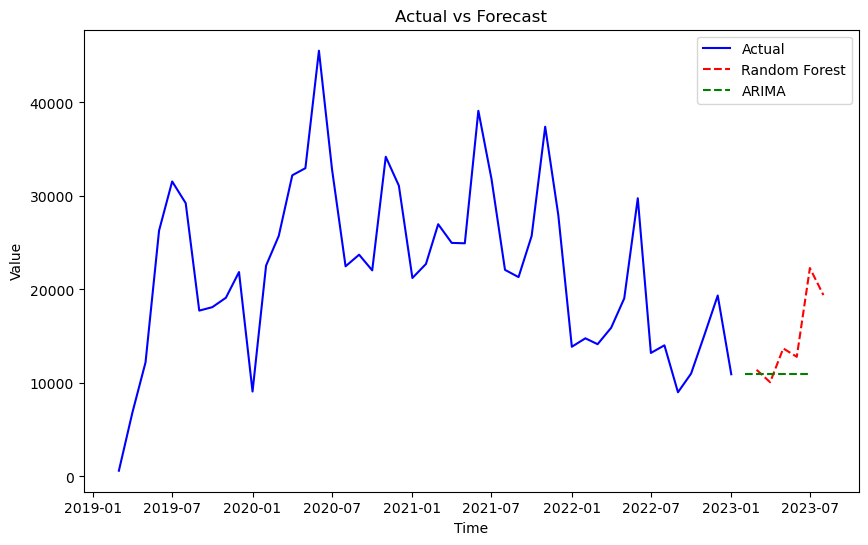

In [1006]:
last_date = df[df['Product']=='ProductA'].index[-1]

# Generate a DateTime index for sales_A_rf starting the month after the last_date for a length of the forecast made with the random forest model
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=len(sales_A_rf), freq='M')

# Convert sales_A_rf to a Pandas Series with the newly created DateTime index since the model output is a list
sales_A_rf_series = pd.Series(sales_A_rf, index=forecast_index)

# Plot the actual and forecasted (both by RF and Arima) sales for Product A
plt.figure(figsize=(10, 6)) 
plt.plot(df[df['Product']=='ProductA'].index, df[df['Product']=='ProductA']['Sales'], label="Actual", color='blue')
plt.plot(sales_A_rf_series.index, sales_A_rf_series, label="Random Forest", color='red', linestyle='--')
plt.plot(forecast_mean_a.index, forecast_mean_a, label="ARIMA", color='green', linestyle='--')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Forecast")
plt.legend()
plt.show()

## B

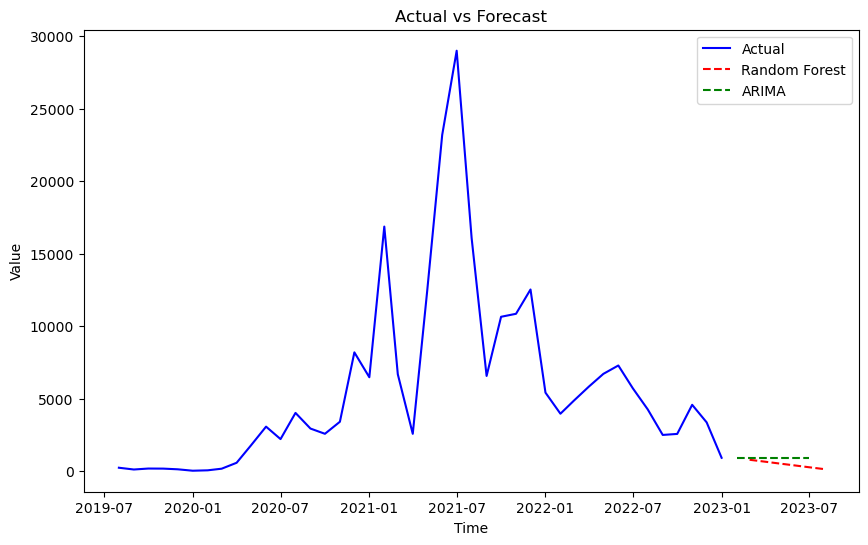

In [1007]:
# Assuming y_a is a Pandas Series with a DateTime index
last_date = df[df['Product']=='ProductB'].index[-1]

# Generate a DateTime index for sales_A_rf starting the month after the last_date
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=len(sales_B_rf), freq='M')

# Convert sales_A_rf to a Pandas Series with the newly created DateTime index
sales_B_rf_series = pd.Series(sales_B_rf, index=forecast_index)

plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(df[df['Product']=='ProductB'].index, df[df['Product']=='ProductB']['Sales'], label="Actual", color='blue')
plt.plot(sales_B_rf_series.index, sales_B_rf_series, label="Random Forest", color='red', linestyle='--')
plt.plot(forecast_mean_b.index, forecast_mean_b, label="ARIMA", color='green', linestyle='--')


plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Forecast")
plt.legend()
plt.show()

## C

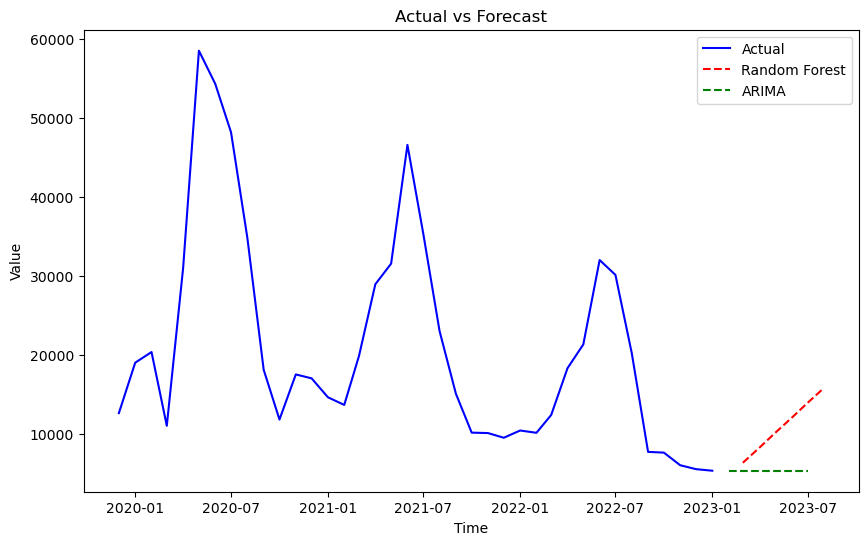

In [1008]:
# Assuming y_a is a Pandas Series with a DateTime index
last_date = df[df['Product']=='ProductC'].index[-1]

# Generate a DateTime index for sales_A_rf starting the month after the last_date
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=len(sales_C_rf), freq='M')

# Convert sales_A_rf to a Pandas Series with the newly created DateTime index
sales_C_rf_series = pd.Series(sales_C_rf, index=forecast_index)

plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(df[df['Product']=='ProductC'].index, df[df['Product']=='ProductC']['Sales'], label="Actual", color='blue')
plt.plot(sales_C_rf_series.index, sales_C_rf_series, label="Random Forest", color='red', linestyle='--')
plt.plot(forecast_mean_c.index, forecast_mean_c, label="ARIMA", color='green', linestyle='--')


plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Forecast")
plt.legend()
plt.show()

# Conclusion

To conclude, the best model to perform time series predicitons, in this case, is Random Forest. <br>
About the product predictions, product A will follow the same path as the one of past months having an increase in the last part of the forecast period.<br>
Product B will stabilize having low values of sales, having the same behaviour that it had at the beginning of its selling period. <br>
Lastly product C will have a steep increase iin sales having probably the same pick adn drop behaviour as in the past months 

In [1010]:
# Create a DataFrame for the forecasted sales
sales_A_rf_frame=sales_A_rf_series.to_frame().reset_index()
sales_B_rf_frame=sales_B_rf_series.to_frame().reset_index()
sales_C_rf_frame=sales_C_rf_series.to_frame().reset_index()

# Rename the column to 'Sales'
sales_A_rf_frame.columns=['Date','Sales']
sales_B_rf_frame.columns=['Date','Sales']
sales_C_rf_frame.columns=['Date','Sales']

In [1011]:
# if you want to take a deepr look to the forecasted values you can check the csv file that has been created

sales_A_rf_frame.to_csv('sales_A_rf_forecast.csv')
sales_B_rf_frame.to_csv('sales_B_rf_forecast.csv')
sales_C_rf_frame.to_csv('sales_C_rf_forecast.csv')